# Data Preparation

## Objective
Clean and preprocess the dataset for modeling.

## Steps
1. Handle missing or duplicate values
2. Feature engineering and selection
3. Encode categorical variables
4. Split the dataset into training and testing sets
5. Calculate class weights for imbalance handling

## Notes
- Keep transformations consistent with the modeling phase
- All preprocessing steps are documented and reproducible


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)


## 1. Load Data


In [18]:
dataset_path = kagglehub.dataset_download("asaniczka/video-game-sales-2024")
csv_file = [f for f in os.listdir(dataset_path) if f.endswith('.csv')][0]
file_path = os.path.join(dataset_path, csv_file)

# load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at {file_path}. Please check the path.")


print(f"Original dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(3)


Dataset loaded successfully.
Original dataset shape: (64016, 14)

First few rows:


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN


## 2. Missing Value Analysis


In [19]:
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)


,Missing_Count,Percentage
critic_score,57338,89.568233
jp_sales,57290,89.493252
na_sales,51379,80.259623
pal_sales,51192,79.967508
other_sales,48888,76.368408
last_update,46137,72.071045
total_sales,45094,70.441765
release_date,7051,11.014434
developer,17,0.026556


## 3. Missing Value Handling

### Strategy:
1. **total_sales**:
   - If missing but regional sales exist (na_sales + pal_sales at minimum), calculate total_sales
   - Only drop rows if both na_sales AND pal_sales are missing
2. **critic_score**: Fill with median by genre + add `has_critic_score` flag
3. **developer/publisher**: Fill with "Unknown", better than dropping
4. **other columns**: Handle as needed


In [20]:
# Step 1: Handle total_sales
print(f"Rows with missing total_sales: {df['total_sales'].isnull().sum()}")

# Drop rows where BOTH na_sales AND pal_sales are missing (can't recover total_sales)
rows_before = len(df)
df = df.dropna(subset=['na_sales', 'pal_sales'], how='all')
rows_after = len(df)
print(f"Dropped {rows_before - rows_after} rows with missing both NA and PAL sales")
print(f"Dataset shape after dropping unrecoverable rows: {df.shape}")

# Calculate total_sales for rows where it's missing but regional sales exist
missing_total_mask = df['total_sales'].isnull()
if missing_total_mask.sum() > 0:
    print(f"\nRecalculating total_sales for {missing_total_mask.sum()} rows...")

    # Fill missing regional sales with 0 before calculation
    df['na_sales'].fillna(0, inplace=True)
    df['jp_sales'].fillna(0, inplace=True)
    df['pal_sales'].fillna(0, inplace=True)
    df['other_sales'].fillna(0, inplace=True)

    # Calculate total_sales where missing
    df.loc[missing_total_mask, 'total_sales'] = (
        df.loc[missing_total_mask, 'na_sales'] +
        df.loc[missing_total_mask, 'jp_sales'] +
        df.loc[missing_total_mask, 'pal_sales'] +
        df.loc[missing_total_mask, 'other_sales']
    )

    print(f"Recalculated total_sales for {missing_total_mask.sum()} rows")
    print(f"Remaining missing total_sales: {df['total_sales'].isnull().sum()}")

# Final check: drop any remaining rows with missing total_sales (edge cases)
if df['total_sales'].isnull().sum() > 0:
    df = df.dropna(subset=['total_sales'])
    print(f"Dropped {df['total_sales'].isnull().sum()} remaining rows with missing total_sales")

print(f"\nFinal dataset shape: {df.shape}")

# Step 2: Handle critic_score - add binary flag first
df['has_critic_score'] = df['critic_score'].notna().astype(int)
print(f"\nGames with critic scores: {df['has_critic_score'].sum()} ({df['has_critic_score'].mean()*100:.1f}%)")

# Fill missing critic_score with median by genre
genre_median_scores = df.groupby('genre')['critic_score'].median()
print("\nMedian critic scores by genre:")
print(genre_median_scores)

df['critic_score'] = df.apply(
    lambda row: genre_median_scores[row['genre']] if pd.isna(row['critic_score']) else row['critic_score'],
    axis=1
)

# If still any NaN (genre with no scores), fill with overall median
overall_median = df['critic_score'].median()
df['critic_score'].fillna(overall_median, inplace=True)

# Step 3: Handle missing developer and publisher
df['developer'].fillna('Unknown', inplace=True)
df['publisher'].fillna('Unknown', inplace=True)

# Step 4: Handle release_date - fill missing with a default or drop
print(f"\nMissing release_date: {df['release_date'].isnull().sum()}")
# We'll handle this in feature engineering

print("\n" + "="*60)
print("Missing Values After Handling:")
print("="*60)
missing_after = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df)) * 100
})
print(missing_after[missing_after['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))


Rows with missing total_sales: 45094
Dropped 49225 rows with missing both NA and PAL sales
Dataset shape after dropping unrecoverable rows: (14791, 14)

Final dataset shape: (14791, 14)

Games with critic scores: 4026 (27.2%)

Median critic scores by genre:
genre
Action              6.80
Action-Adventure    7.65
Adventure           7.10
Board Game          5.30
Education           7.75
Fighting            7.50
MMO                 7.25
Misc                7.10
Music               7.70
Party               5.70
Platform            7.00
Puzzle              7.30
Racing              7.40
Role-Playing        7.50
Sandbox             9.20
Shooter             7.50
Simulation          7.00
Sports              7.80
Strategy            7.70
Visual Novel        9.00
Name: critic_score, dtype: float64

Missing release_date: 56

Missing Values After Handling:
              Missing_Count  Percentage
jp_sales              12196   82.455547
last_update           11822   79.926983
na_sales               

## 4. Define Target Variable


Target Distribution:
target
0    13314
1     1477
Name: count, dtype: int64

Target Percentage:
target
0    90.014198
1     9.985802
Name: proportion, dtype: float64


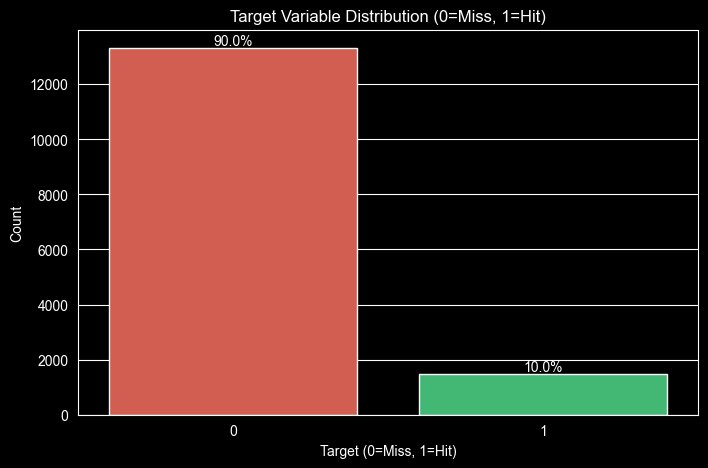

In [23]:
# Define target: Hit (1) if total_sales >= 1M, else Miss (0)
df['target'] = (df['total_sales'] >= 1.0).astype(int)

print("Target Distribution:")
print(df['target'].value_counts())
print("\nTarget Percentage:")
print(df['target'].value_counts(normalize=True) * 100)

# Visualize
plt.figure(figsize=(8, 5))
colors = ['#E74C3C', '#2ECC71']
ax = sns.countplot(x='target', data=df, palette=colors, hue='target', legend=False)
plt.title('Target Variable Distribution (0=Miss, 1=Hit)')
plt.xlabel('Target (0=Miss, 1=Hit)')
plt.ylabel('Count')

# Add percentages
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()


## 5. Feature Engineering


In [24]:
# Extract release year from release_date
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

# Fill missing years with median year
median_year = df['release_year'].median()
df['release_year'].fillna(median_year, inplace=True)

# Create age of game feature (years since release)
current_year = 2025
df['game_age'] = current_year - df['release_year']

print("New Features Created:")
print("- release_year")
print("- game_age")
print("- has_critic_score")
print(f"\nDataset shape: {df.shape}")


New Features Created:
- release_year
- game_age
- has_critic_score

Dataset shape: (14791, 18)


## 6. Feature Selection

### Drop irrelevant features:
- `img`: Not useful for prediction
- `last_update`: Not useful for prediction
- `release_date`: Extracted year already
- `title`: Too unique, not useful without NLP


In [25]:
# Columns to drop
drop_cols = ['img', 'last_update', 'release_date', 'title']
existing_drop_cols = [col for col in drop_cols if col in df.columns]

print(f"Dropping columns: {existing_drop_cols}")
df = df.drop(columns=existing_drop_cols)

print(f"\nDataset shape after dropping: {df.shape}")
print("\nRemaining columns:")
print(df.columns.tolist())


Dropping columns: ['img', 'last_update', 'release_date', 'title']

Dataset shape after dropping: (14791, 14)

Remaining columns:
['console', 'genre', 'publisher', 'developer', 'critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales', 'has_critic_score', 'target', 'release_year', 'game_age']


## 7. Handle Duplicates


In [26]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df.shape}")


Number of duplicate rows: 53
Dataset shape after removing duplicates: (14738, 14)


## 8. Categorical Variable Simplification

### Reduce high-cardinality categorical features:
- **Console**: Top 10 + "Other"
- **Publisher**: Top 10 + "Other"
- **Developer**: Top 10 + "Other"
- **Genre**: Keep all (already manageable)


In [27]:
def simplify_categorical(df, column, top_n=10):
    """Simplify high-cardinality categorical column to top N + 'Other'"""
    top_categories = df[column].value_counts().nlargest(top_n).index
    df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')
    return df

# Simplify console
print("Simplifying Console (Top 10 + Other)...")
print(f"Original unique consoles: {df['console'].nunique()}")
df = simplify_categorical(df, 'console', top_n=10)
print(f"After simplification: {df['console'].nunique()}")
print(df['console'].value_counts())

print("\n" + "="*60)

# Simplify publisher
print("Simplifying Publisher (Top 10 + Other)...")
print(f"Original unique publishers: {df['publisher'].nunique()}")
df = simplify_categorical(df, 'publisher', top_n=10)
print(f"After simplification: {df['publisher'].nunique()}")
print(df['publisher'].value_counts())

print("\n" + "="*60)

# Simplify developer
print("Simplifying Developer (Top 10 + Other)...")
print(f"Original unique developers: {df['developer'].nunique()}")
df = simplify_categorical(df, 'developer', top_n=10)
print(f"After simplification: {df['developer'].nunique()}")
print(df['developer'].value_counts())

print("\n" + "="*60)

# Genre - keep all (already manageable)
print(f"Genre unique values: {df['genre'].nunique()}")
print(df['genre'].value_counts())


Simplifying Console (Top 10 + Other)...
Original unique consoles: 32
After simplification: 11
console
Other    2988
DS       1743
PS2      1590
PC       1542
Wii      1242
X360     1209
PS3      1094
PS        929
XB        831
GBA       812
PS4       758
Name: count, dtype: int64

Simplifying Publisher (Top 10 + Other)...
Original unique publishers: 512
After simplification: 11
publisher
Other                          8631
Activision                     1042
Ubisoft                         995
Electronic Arts                 824
THQ                             724
EA Sports                       535
Sony Computer Entertainment     469
Konami                          468
Sega                            408
Atari                           333
Capcom                          309
Name: count, dtype: int64

Simplifying Developer (Top 10 + Other)...
Original unique developers: 2522
After simplification: 11
developer
Other                12924
EA Canada              288
Konami               

## 9. One-Hot Encoding for Categorical Variables


In [28]:
# Identify categorical columns to encode
categorical_cols = ['console', 'genre', 'publisher', 'developer']

print("Applying One-Hot Encoding to:")
print(categorical_cols)

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

print(f"\nDataset shape after encoding: {df_encoded.shape}")
print(f"New features created: {df_encoded.shape[1] - df.shape[1] + len(categorical_cols)}")


Applying One-Hot Encoding to:
['console', 'genre', 'publisher', 'developer']

Dataset shape after encoding: (14738, 59)
New features created: 49


## 10. Prepare Features and Target


In [29]:
# Separate features and target
# IMPORTANT: Remove all sales-related columns to avoid data leakage
# total_sales is used ONLY to create the target variable
# Regional sales (na_sales, jp_sales, pal_sales, other_sales) sum to total_sales

exclude_from_features = [
    'target',
    'total_sales',      # This is what we're predicting (via Hit/Miss)
    'na_sales',         # Regional sales are components of total_sales
    'jp_sales',         # Including them would be data leakage
    'pal_sales',
    'other_sales'
]

feature_cols = [col for col in df_encoded.columns if col not in exclude_from_features]

X = df_encoded[feature_cols]
y = df_encoded['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nExcluded columns (to avoid data leakage): {exclude_from_features}")
print(f"\nFeature columns ({len(feature_cols)}):")
print(feature_cols)


Features shape: (14738, 53)
Target shape: (14738,)

Excluded columns (to avoid data leakage): ['target', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']

Feature columns (53):
['critic_score', 'has_critic_score', 'release_year', 'game_age', 'console_GBA', 'console_Other', 'console_PC', 'console_PS', 'console_PS2', 'console_PS3', 'console_PS4', 'console_Wii', 'console_X360', 'console_XB', 'genre_Action-Adventure', 'genre_Adventure', 'genre_Board Game', 'genre_Education', 'genre_Fighting', 'genre_MMO', 'genre_Misc', 'genre_Music', 'genre_Party', 'genre_Platform', 'genre_Puzzle', 'genre_Racing', 'genre_Role-Playing', 'genre_Sandbox', 'genre_Shooter', 'genre_Simulation', 'genre_Sports', 'genre_Strategy', 'genre_Visual Novel', 'publisher_Atari', 'publisher_Capcom', 'publisher_EA Sports', 'publisher_Electronic Arts', 'publisher_Konami', 'publisher_Other', 'publisher_Sega', 'publisher_Sony Computer Entertainment', 'publisher_THQ', 'publisher_Ubisoft', 'developer_Capcom', 'd

## 11. Train-Test Split (Stratified)

### Using 80/20 split with stratification to maintain class balance


In [30]:
# Stratified split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train-Test Split Results:")
print("="*60)
print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True) * 100)

print(f"\nTest set target distribution:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True) * 100)


Train-Test Split Results:
Training set size: 11790 (80.0%)
Test set size: 2948 (20.0%)

Training set target distribution:
target
0    10608
1     1182
Name: count, dtype: int64
target
0    89.974555
1    10.025445
Name: proportion, dtype: float64

Test set target distribution:
target
0    2653
1     295
Name: count, dtype: int64
target
0    89.993216
1    10.006784
Name: proportion, dtype: float64


## 12. Feature Scaling (Optional for some models)

### Note: Tree-based models (Random Forest, XGBoost) don't need scaling
### But we'll prepare scaled versions for models like Logistic Regression


In [31]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature Scaling Complete")
print("- Fitted StandardScaler on training data")
print("- Applied to both train and test sets")


Feature Scaling Complete
- Fitted StandardScaler on training data
- Applied to both train and test sets


## 13. Calculate Class Weights

### For handling class imbalance in modeling


In [32]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class Weights for Imbalanced Data:")
print("="*60)
print(f"Class 0 (Miss): {class_weight_dict[0]:.4f}")
print(f"Class 1 (Hit): {class_weight_dict[1]:.4f}")
print(f"\nWeight ratio (Hit/Miss): {class_weight_dict[1]/class_weight_dict[0]:.2f}")


Class Weights for Imbalanced Data:
Class 0 (Miss): 0.5557
Class 1 (Hit): 4.9873

Weight ratio (Hit/Miss): 8.97


## 14. Save Processed Data


In [33]:
# Save processed datasets
output_dir = '../data/processed/'

# Save train/test splits (unscaled)
X_train.to_csv(output_dir + 'X_train.csv', index=False)
X_test.to_csv(output_dir + 'X_test.csv', index=False)
y_train.to_csv(output_dir + 'y_train.csv', index=False)
y_test.to_csv(output_dir + 'y_test.csv', index=False)

# Save scaled versions
X_train_scaled.to_csv(output_dir + 'X_train_scaled.csv', index=False)
X_test_scaled.to_csv(output_dir + 'X_test_scaled.csv', index=False)

# Save class weights
pd.DataFrame([class_weight_dict]).to_csv(output_dir + 'class_weights.csv', index=False)

# Save feature names for reference
pd.DataFrame({'feature': feature_cols}).to_csv(output_dir + 'feature_names.csv', index=False)

print("All processed data saved to:", output_dir)
print("\nSaved files:")
print("- X_train.csv, X_test.csv")
print("- y_train.csv, y_test.csv")
print("- X_train_scaled.csv, X_test_scaled.csv")
print("- class_weights.csv")
print("- feature_names.csv")


All processed data saved to: ../data/processed/

Saved files:
- X_train.csv, X_test.csv
- y_train.csv, y_test.csv
- X_train_scaled.csv, X_test_scaled.csv
- class_weights.csv
- feature_names.csv
